**Feature Extraction Example**

In [108]:
import librosa
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from IPython.display import Audio, display


In [109]:
y, sr = librosa.load("../data/nsynth-test/audio/keyboard_acoustic_004-053-025.wav", sr=None, mono=True)
display(Audio(y, rate=sr)) 


**F0**

The f0 (Fundamental Frequency) is the pitch of a sound. Timbre Transfer Context: When you transfer timbre, you keep the f0 of the source audio (what you are singing or playing) and apply the spectral characteristics (the harmonics and noise) of the target instrument. For example, if you sing a 'C4' (which has a certain f0), the system ensures the output instrument also plays a 'C4', maintaining the original melody. \
The YIN algorithm (which librosa.pyin uses) is a highly reliable way to find the f0. \
It works like an Echo Detector: it takes the sound wave and quickly checks how similar it is to slightly delayed versions of itself. The delay time that makes the sound wave perfectly align with its delayed copy is the period (the time for one pitch cycle). YIN then converts that period into the f0 (pitch).

In [110]:
f0, voiced_flag, voiced_probs = librosa.pyin(
    y,
    sr=sr,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

In [111]:
f0

array([173.60841241, 175.625645  , 174.61411572, 174.61411572,
       174.61411572, 174.61411572, 174.61411572, 174.61411572,
       174.61411572, 174.61411572, 174.61411572, 174.61411572,
       174.61411572, 174.61411572, 174.61411572, 174.61411572,
       174.61411572, 174.61411572, 174.61411572, 174.61411572,
       174.61411572, 173.60841241, 174.61411572, 174.61411572,
       173.60841241, 173.60841241, 174.61411572, 173.60841241,
       174.61411572, 173.60841241, 174.61411572, 173.60841241,
       173.60841241, 173.60841241, 174.61411572, 174.61411572,
       174.61411572, 174.61411572, 173.60841241, 173.60841241,
       173.60841241, 173.60841241, 173.60841241, 173.60841241,
       173.60841241, 173.60841241, 173.60841241, 173.60841241,
       173.60841241, 173.60841241, 173.60841241, 173.60841241,
       173.60841241, 173.60841241, 173.60841241, 173.60841241,
       173.60841241, 173.60841241, 173.60841241, 173.60841241,
       173.60841241, 173.60841241, 173.60841241, 173.60

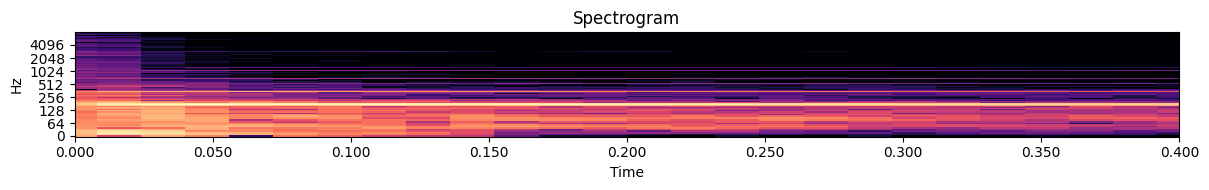

In [112]:
S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(12,2))
librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', y_axis='log', fmin=50, fmax=4000)
plt.title("Spectrogram")
plt.tight_layout()
t0, t1 = 0.0, 0.40   # seconds
plt.xlim(t0, t1)   
plt.show()


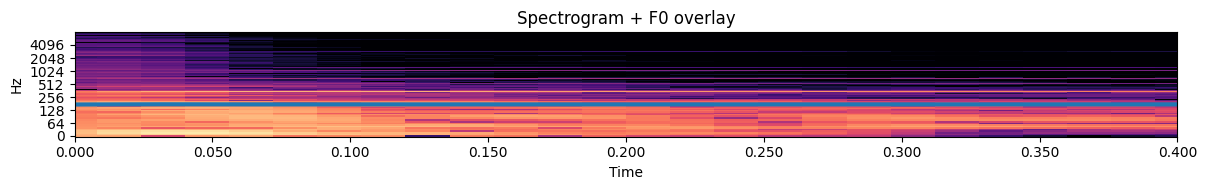

In [113]:
S = np.abs(librosa.stft(y, n_fft=2048, hop_length=256))
S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(12,2))
librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', y_axis='log', fmin=50, fmax=4000)
plt.plot(times[voiced_flag], f0[voiced_flag], linewidth=3)
plt.title("Spectrogram + F0 overlay")
plt.tight_layout()
t0, t1 = 0.0, 0.40
plt.xlim(t0, t1)   
plt.show()

Plots Interpratation as a check of correctness of extraction: \
The horizontal bands represent the harmonics of the note. The lowest band is the true Fundamental Frequency f0 which is around 128 Hz on plot. 
The blue line - our detected f0, which is perfectly align with target spectogram band.

**Perceived Loudness**

Perceived Loudness is a feature that models how human ears perceive the volume of a sound, which is crucial for controlling the dynamics and energy contour of the target instrument during timbre transfer. \
Algorithm used: A-Weighting: The perceived loudness calculation uses a frequency filter A-weighting to boost the frequencies we hear best and attenuate those we hear poorly. This ensures that if the source sound's pitch is very high (which is naturally quieter to our ears), the transfer process doesn't compensate by making the target instrument artificially loud.

In [114]:
def compute_perceived_loudness(
    y, sr=16000, n_fft=2048, hop_length=512, 
    smoothing_window_frames=15,
    floor_db=-60.0, ref_percentile=95
):
    y = np.asarray(y, dtype=np.float32)
    
    peak = np.max(np.abs(y))
    if peak < 1e-6:
        N_frames = librosa.util.frame(y, frame_length=n_fft, hop_length=hop_length).shape[1]
        return np.zeros(N_frames, dtype=np.float32)

    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    P = (S ** 2)

    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    A_db = librosa.A_weighting(freqs)
    A_lin = 10.0 ** (A_db / 20.0) 
    P_aw = P * (A_lin[:, None] ** 2) 
    pow_aw = np.sum(P_aw, axis=0) + 1e-12 
    loud_db = 10.0 * np.log10(pow_aw) 

    if smoothing_window_frames > 1:
        if smoothing_window_frames % 2 == 0:
            smoothing_window_frames += 1
        loud_db_smoothed = median_filter(
            loud_db, 
            size=smoothing_window_frames 
        )
    else:
        loud_db_smoothed = loud_db

    ref_db = np.percentile(loud_db_smoothed, ref_percentile)
    loud_rel = loud_db_smoothed - ref_db 
    loud_rel = np.clip(loud_rel, floor_db, 0.0)
    loud_unit = (loud_rel - floor_db) / (-floor_db) 

    return loud_unit.astype(np.float32)

In [115]:
loudness = compute_perceived_loudness(y)

In [116]:
loudness

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99095297,
       0.9863878 , 0.9844364 , 0.9760986 , 0.9692107 , 0.9624712 ,
       0.95219564, 0.9430562 , 0.93515855, 0.9304908 , 0.9266103 ,
       0.91872746, 0.9120348 , 0.908315  , 0.90021116, 0.8956669 ,
       0.8922246 , 0.88724077, 0.88156074, 0.8779092 , 0.87373537,
       0.8698018 , 0.8672533 , 0.86278313, 0.8538465 , 0.8473162 ,
       0.8462389 , 0.843329  , 0.84282064, 0.84149474, 0.83792144,
       0.83653885, 0.834495  , 0.8270666 , 0.8232851 , 0.821313  ,
       0.81672746, 0.8096383 , 0.80357796, 0.8027957 , 0.80261666,
       0.7986481 , 0.79854745, 0.7981009 , 0.78850454, 0.7777782 ,
       0.77044606, 0.7684837 , 0.7667626 , 0.7638406 , 0.75608045,
       0.7485208 , 0.74227595, 0.74102837, 0.7377633 , 0.7342932 ,
       0.7237532 , 0.7158335 , 0.70743436, 0.7062881 , 0.70546556,
       0.7022211 , 0.69450027, 0.68472683, 0.6756079 , 0.66373

In [117]:
len(loudness)

126

In [118]:
times = librosa.frames_to_time(np.arange(len(loudness)), sr=sr, hop_length=512)

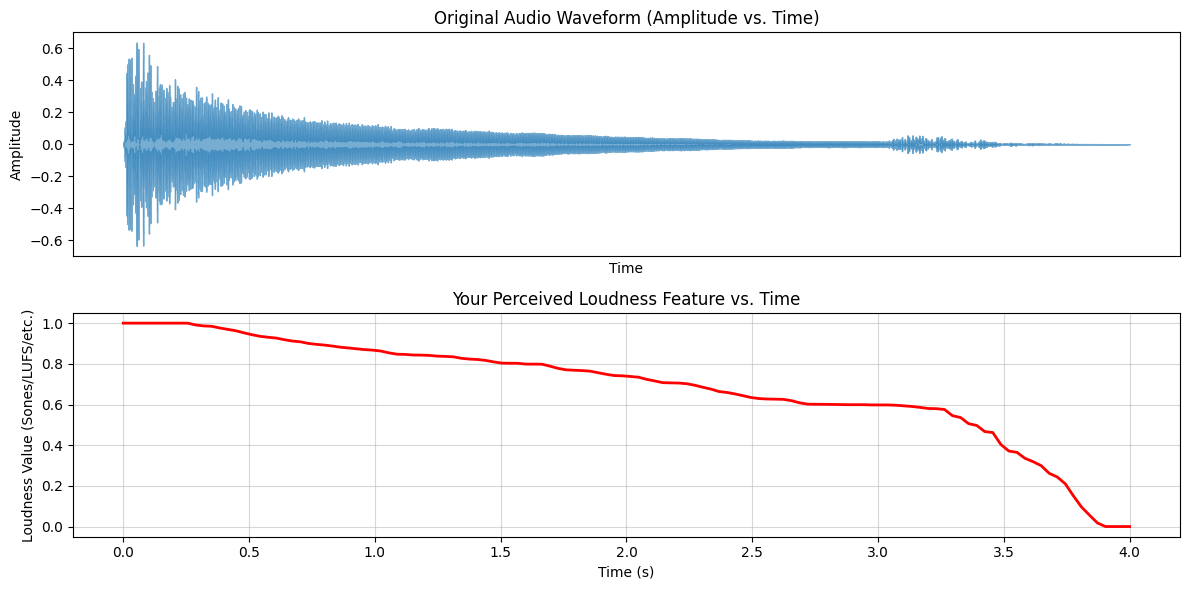

In [119]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title('Original Audio Waveform (Amplitude vs. Time)')
plt.ylabel('Amplitude')
plt.xticks([])

plt.subplot(2, 1, 2)
plt.plot(times, loudness, color='red', linewidth=2)
plt.title('Your Perceived Loudness Feature vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Loudness Value (Sones/LUFS/etc.)')
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

Waveform shows hows the raw audio, providing context for the amplitude. The bottom plot shows the red line, which represents the volume level on a 0 to 1 scale. The curve starts at the maximum volume 1.0 and shows a smooth, gradual decay over the first half-second. From about 0.5 s to 3.0 s, the loudness curve shows a steady, slow decline. The drop-off between 3.0 s and 3.5 s accurately reflects the final burst of energy before the sound decays completely to silence 0.

**OnSet**

The Onset feature is aswell importantr for timbre transfer process. It marks the precise moment in time when a new sound event begins. The Onset feature tells the synthesis system when to start or other sound event. Without accurate onsets, the output would have sloppy timing or sound like a continuous drone. Onset detection relies on finding sudden, significant increases in the signal's energy, which often correspond to the sharp attack of a note.

In [120]:
onset_envelope = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512)

In [121]:
onset_frames = librosa.util.peak_pick(
    x=onset_envelope,
    pre_max=3,
    post_max=3,
    pre_avg=3,
    post_avg=5,
    delta=0.20,     
    wait=2     
)

In [122]:
N_FRAMES_TARGET = len(f0)
onset_vector = np.zeros(N_FRAMES_TARGET)
onset= librosa.frames_to_time(onset_frames, sr=sr)
times = librosa.frames_to_time(np.arange(len(onset_envelope)), sr=sr)
for frame_idx in onset_frames:
    if frame_idx < N_FRAMES_TARGET:
        onset_vector[frame_idx] = 1

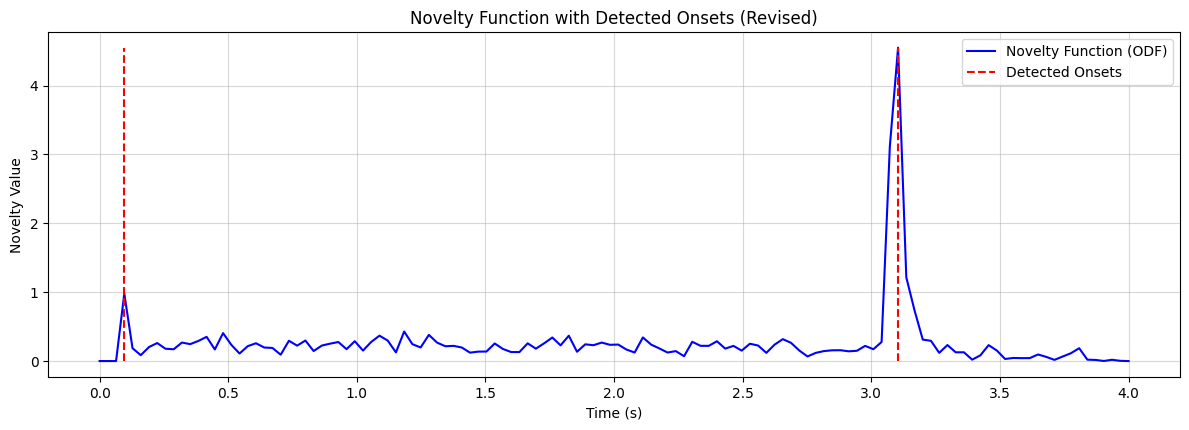

In [123]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 2)
plt.plot(times, onset_envelope, color='b', label='Novelty Function (ODF)')
plt.vlines(onset, onset_envelope.min(), onset_envelope.max(), color='r', linestyle='--', linewidth=1.5, label='Detected Onsets')
plt.title('Novelty Function with Detected Onsets (Revised)')
plt.xlabel('Time (s)')
plt.ylabel('Novelty Value')
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

In [124]:
result = list(zip(f0, loudness, onset_vector))

In [125]:
result

[(np.float64(173.60841241450115), np.float32(1.0), np.float64(0.0)),
 (np.float64(175.62564499846297), np.float32(1.0), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(1.0), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(1.0), np.float64(1.0)),
 (np.float64(174.61411571650194), np.float32(1.0), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(1.0), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(1.0), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(1.0), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(1.0), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(0.99095297), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(0.9863878), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(0.9844364), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(0.9760986), np.float64(0.0)),
 (np.float64(174.61411571650194), np.float32(0.9692107), np.float64(0.0)),
 (n

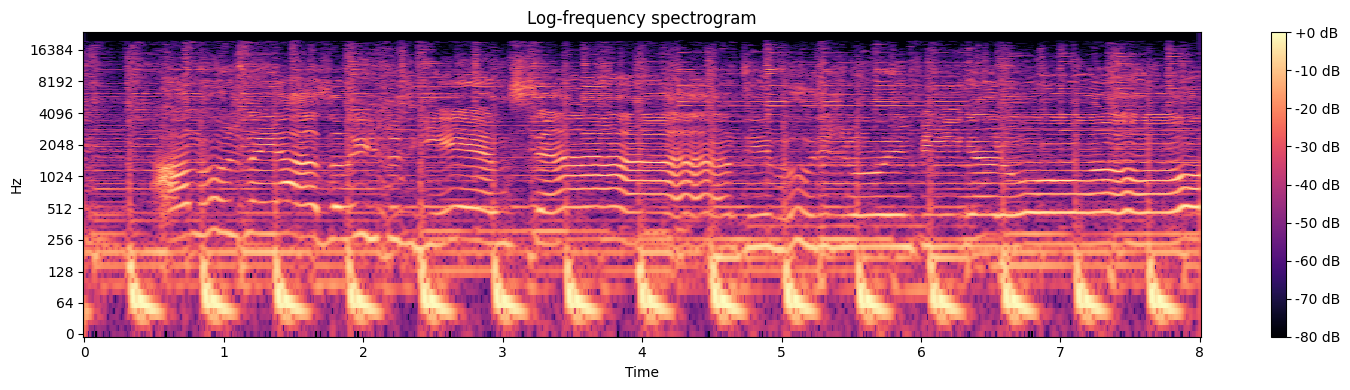

In [126]:
path = "DREVO - ГЕНГСТА - DREVO.mp3"
y, sr = librosa.load(path, sr=None, mono=True)

start_s, end_s = 6.0, 14.0 
i0, i1 = int(start_s*sr), int(end_s*sr)
y_seg = y[i0:i1] if i1 > i0 else y

n_fft, hop = 4096, 512
S = np.abs(librosa.stft(y_seg, n_fft=n_fft, hop_length=hop))
S_db = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(15,4))
librosa.display.specshow(S_db, sr=sr, hop_length=hop,
                         x_axis='time', y_axis='log', fmin=30, fmax=sr/2)
plt.colorbar(format="%+0.0f dB")
plt.title("Log-frequency spectrogram")
plt.tight_layout(); plt.show()